# Image Caption with Attention

## Setup

In [142]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import random
import json
import collections
import pathlib
import re
import einops
import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [143]:
DATASET_RAW = "../datasets/flickr/raw"
DATASET_INTERIM = "../datasets/flickr/interim"
CHECKPOINTS = "../checkpoints/flickr"
OUTPUTS = "../outputs/baseline"

## Data Handling

### Dataset

In [144]:
def flickr8k(path="flickr8k"):
    path = pathlib.Path(path)

    captions = (path / "Flickr8k.token.txt").read_text().splitlines()
    captions = (line.split("\t") for line in captions)
    captions = ((fname.split("#")[0], caption) for (fname, caption) in captions)

    cap_dict = collections.defaultdict(list)
    for fname, cap in captions:
        cap_dict[fname].append(cap)

    train_files = (path / "Flickr_8k.trainImages.txt").read_text().splitlines()
    train_captions = [
        (str(path / "Images" / fname), cap_dict[fname])
        for fname in train_files
    ]

    test_files = (path / "Flickr_8k.testImages.txt").read_text().splitlines()
    test_captions = [
        (str(path / "Images" / fname), cap_dict[fname])
        for fname in test_files
    ]

    train_ds = tf.data.experimental.from_list(train_captions)
    test_ds = tf.data.experimental.from_list(test_captions)

    return train_ds, test_ds

In [145]:
train_raw, test_raw = flickr8k(DATASET_RAW)

The loaders for both datasets above return `tf.data.Dataset`s containing `(image_path, captions)` pairs. The Flickr8k dataset contains 5 captions per image:

In [146]:
for ex_path, ex_captions in train_raw.take(1):
    print(ex_path)
    print(ex_captions)

tf.Tensor(b'../datasets/flickr/raw/Images/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


In [147]:
train_raw.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.string, name=None))>

### Image feature extractor

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


In [148]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True
)
mobilenet.trainable=False

Here's a function to load an image and resize it for the model:

In [149]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

The model returns a feature map for each image in the input batch:

In [150]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


### Setup the text tokenizer/vectorizer

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [151]:
def standardize(s):
    s = tf.strings.lower(s)
    s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
    s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
    return s

In [152]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [153]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [154]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']

In [155]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 655, 5, 2, 97, 4], [3, 2, 1937, 10, 4]]>

In [156]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary()
)

index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True
)

In [157]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [158]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Prepare the datasets

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs.

This function will replicate the image so there are 1:1 images to captions:

In [159]:
def match_shapes(images, captions):
    caption_shape = einops.parse_shape(captions, 'b c')
    captions = einops.rearrange(captions, 'b c -> (b c)')
    images = einops.repeat(
        images, 'b ... -> (b c) ...',
        c = caption_shape['c'])
    return images, captions

In [160]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
    break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [161]:
def prepare_txt(imgs, txts):
    tokens = tokenizer(txts)

    input_tokens = tokens[..., :-1]
    label_tokens = tokens[..., 1:]
    return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [162]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
    ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

    def to_tensor(inputs, labels):
        (images, in_tok), out_tok = inputs, labels
        return (images, in_tok.to_tensor()), out_tok.to_tensor()

    return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [163]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

You could install the feature extractor in your model and train on the datasets like this:

In [165]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`:

In [166]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
    # Load the images and make batches.
    ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

    # Run the feature extractor on each batch
    # Don't do this in a .map, because tf.data runs on the CPU.
    def gen():
        for (images, captions) in tqdm.tqdm(ds):
            feature_maps = image_model(images)

            feature_maps, captions = match_shapes(feature_maps, captions)
            yield feature_maps, captions

    # Wrap the generator in a new tf.data.Dataset.
    new_ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=image_model.output_shape),
            tf.TensorSpec(shape=(None,), dtype=tf.string)
        )
    )

    # Apply the tokenization
    new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

    # Save the dataset into shard files.
    def shard_func(i, item):
        return i % shards
    new_ds.enumerate().save(save_path, shard_func=shard_func)


def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
    def custom_reader_func(datasets):
        datasets = datasets.shuffle(1000)
        return datasets.interleave(lambda x: x, cycle_length=cycle_length)

    ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

    def drop_index(i, x):
        return x

    ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
    return ds

In [80]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

2023-12-03 01:17:13.433354: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
188it [02:48,  1.12it/s]
2023-12-03 01:20:02.259201: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
32it [00:28,  1.11it/s]


## Data ready for training

After those preprocessing steps, here are the datasets:

In [167]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [168]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [169]:
for (inputs, ex_labels) in train_ds.take(1):
    (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 19)
(32, 19)


In [177]:
for (inputs, ex_labels) in train_ds.take(2):
    (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 19)
(32, 19)


The input tokens and the labels are the same, just shifted by 1 step:

In [178]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3   6  16   9  15  10  70  11   2 141  39   5  77  68   0   0   0   0
   0]
[  6  16   9  15  10  70  11   2 141  39   5  77  68   4   0   0   0   0
   0]


## A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts:

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs.

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [171]:
class SeqEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, max_length, depth):
        super().__init__()
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

        self.token_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=depth,
            mask_zero=True)

        self.add = tf.keras.layers.Add()

    def call(self, seq):
        seq = self.token_embedding(seq) # (batch, seq, depth)

        x = tf.range(tf.shape(seq)[1])  # (seq)
        x = x[tf.newaxis, :]  # (1, seq)
        x = self.pos_embedding(x)  # (1, seq, depth)

        return self.add([seq,x])

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [172]:
class CausalSelfAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        # Use Add instead of + so the keras mask propagates through.
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        attn = self.mha(query=x, value=x,
                        use_causal_mask=True)
        x = self.add([x, attn])
        return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [173]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x, y, **kwargs):
        attn, attention_scores = self.mha(
                 query=x, value=y,
                 return_attention_scores=True)

        self.last_attention_scores = attention_scores

        x = self.add([x, attn])
        return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [174]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, units, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(units=2*units, activation='relu'),
            tf.keras.layers.Dense(units=units),
            tf.keras.layers.Dropout(rate=dropout_rate),
        ])

        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = x + self.seq(x)
        return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [175]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=1, dropout_rate=0.1):
        super().__init__()

        self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                                  key_dim=units,
                                                  dropout=dropout_rate)
        self.cross_attention = CrossAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
        self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


    def call(self, inputs, training=False):
        in_seq, out_seq = inputs

        # Text input
        out_seq = self.self_attention(out_seq)

        out_seq = self.cross_attention(out_seq, in_seq)

        self.last_attention_scores = self.cross_attention.last_attention_scores

        out_seq = self.ff(out_seq)

        return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`,
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well.

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [176]:
#@title
class TokenOutput(tf.keras.layers.Layer):
    def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
        super().__init__()

        self.dense = tf.keras.layers.Dense(
            units=tokenizer.vocabulary_size(), **kwargs)
        self.tokenizer = tokenizer
        self.banned_tokens = banned_tokens

        self.bias = None

    def adapt(self, ds):
        counts = collections.Counter()
        vocab_dict = {name: id
                      for id, name in enumerate(self.tokenizer.get_vocabulary())}

        for tokens in tqdm.tqdm(ds):
            counts.update(tokens.numpy().flatten())

        counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
        counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

        counts_arr = counts_arr[:]
        for token in self.banned_tokens:
            counts_arr[vocab_dict[token]] = 0

        total = counts_arr.sum()
        p = counts_arr/total
        p[counts_arr==0] = 1.0
        log_p = np.log(p)  # log(1) == 0

        entropy = -(log_p*p).sum()

        print()
        print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
        print(f"Marginal entropy: {entropy:0.2f}")

        self.bias = log_p
        self.bias[counts_arr==0] = -1e9

    def call(self, x):
        x = self.dense(x)
        # TODO(b/250038731): Fix this.
        # An Add layer doesn't work because of the different shapes.
        # This clears the mask, that's okay because it prevents keras from rescaling
        # the losses.
        return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [96]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 938/938 [00:05<00:00, 176.63it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [97]:
class Captioner(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.word_to_index = tf.keras.layers.StringLookup(
            mask_token="",
            vocabulary=tokenizer.get_vocabulary())
        self.index_to_word = tf.keras.layers.StringLookup(
            mask_token="",
            vocabulary=tokenizer.get_vocabulary(),
            invert=True)

        self.seq_embedding = SeqEmbedding(
            vocab_size=tokenizer.vocabulary_size(),
            depth=units,
            max_length=max_length)

        self.decoder_layers = [
            DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
            for n in range(num_layers)]

        self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [98]:
@Captioner.add_method
def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
        # Apply the feature-extractor, if you get an RGB image.
        image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
        # Apply the tokenizer if you get string inputs.
        txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
        txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

In [99]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [100]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 [==============================] - 0s 1us/step


To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [101]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
    initial = self.word_to_index([['[START]']]) # (batch, sequence)
    img_features = self.feature_extractor(image[tf.newaxis, ...])

    tokens = initial # (batch, sequence)
    for n in range(50):
        preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
        preds = preds[:,-1, :]  #(batch, vocab)
        if temperature==0:
            next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
        else:
            next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
        tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

        if next[0] == self.word_to_index('[END]'):
            break
    words = index_to_word(tokens[0, 1:-1])
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    return result.numpy().decode()

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [102]:
for t in (0.0, 0.5, 1.0):
    result = model.simple_gen(image, temperature=t)
    print(result)

a
a a
red dog above brown next distance the along carries pants dog of in a


The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`).

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [103]:
def masked_loss(labels, preds):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

    mask = (labels != 0) & (loss < 1e8)
    mask = tf.cast(mask, loss.dtype)

    loss = loss*mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_acc(labels, preds):
    mask = tf.cast(labels!=0, tf.float32)
    preds = tf.argmax(preds, axis=-1)
    labels = tf.cast(labels, tf.int64)
    match = tf.cast(preds == labels, mask.dtype)
    acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
    return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [104]:
class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self):
        image_url = 'https://tensorflow.org/images/surf.jpg'
        image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
        self.image = load_image(image_path)

    def on_epoch_end(self, epochs=None, logs=None):
        print()
        print()
        for t in (0.0, 0.5, 1.0):
            result = self.model.simple_gen(self.image, temperature=t)
            print(result)
        print()


It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [105]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a
a is
wearing with something outside soccer walking the purple man a white men fence ball racing and skating picture her hike high spots a the ride car by lap



Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [106]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

Configure and execute the training.

In [107]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`.

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [108]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.0055 - masked_acc: 0.2002

a man in a dog is in a in a
a man in a on a dog in a a black
a woman in the dog riding

100/100 [==============================] - 33s 252ms/step - loss: 5.0055 - masked_acc: 0.2002 - val_loss: 4.6844 - val_masked_acc: 0.2409
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.6150 - masked_acc: 0.2566

a man in a dog is in a black and a dog
two dogs in a white dog in a water
a boy while museum jumping of and a tube in ski of another

100/100 [==============================] - 24s 245ms/step - loss: 4.6150 - masked_acc: 0.2566 - val_loss: 4.3610 - val_masked_acc: 0.2785
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.3900 - masked_acc: 0.2773

a man in a red shirt is in a red and a white dog
a man is is in the air
sky on workers are with a air on the and black by a distance

100/100 [==============================] - 25s 249ms/step - loss: 4.

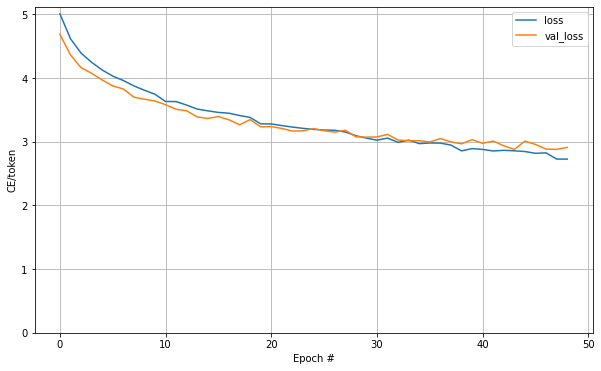

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.grid()
plt.legend()

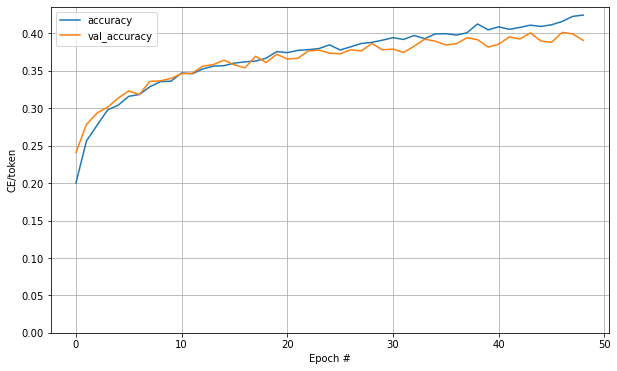

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.grid()
plt.legend()

image## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

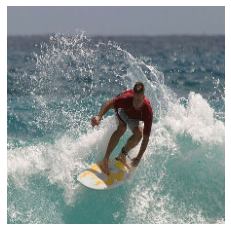

'a man in a red shirt is surfing on a wave'

In [121]:
# Convert the tensor to a NumPy array
image_array = image.numpy()

# Ensure the values are within the range [0, 1]
image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min())

# Display the image
plt.imshow(image_array)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# Predict the result
result = model.simple_gen(image, temperature=0.0)
result

Split the output back into tokens:

In [123]:
model.save('model', save_format='tf')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [124]:
!zip -r model.zip model/

/bin/bash: zip: command not found


In [125]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [129]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([None, 2, 1, 49]), TensorShape([None, 2, 1, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [130]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

TypeError: <tf.Tensor 'cross_attention/multi_head_attention_1/softmax_1/Softmax:0' shape=(None, 2, 1, 49) dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.

<tf.Tensor 'cross_attention/multi_head_attention_1/softmax_1/Softmax:0' shape=(None, 2, 1, 49) dtype=float32> was defined here:
    File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
    File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
    File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
    File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    File "/tmp/ipykernel_2451769/2659559046.py", line 1, in <module>
    File "/opt/conda/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    File "/opt/conda/lib/python3.9/site-packages/keras/src/engine/training.py", line 3103, in save
    File "/opt/conda/lib/python3.9/site-packages/keras/src/saving/saving_api.py", line 167, in save_model
    File "/opt/conda/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    File "/opt/conda/lib/python3.9/site-packages/keras/src/saving/legacy/save.py", line 168, in save_model
    File "/opt/conda/lib/python3.9/site-packages/keras/src/saving/legacy/saved_model/save.py", line 98, in save
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py", line 1371, in save_and_return_nodes
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py", line 1584, in _build_meta_graph
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py", line 1507, in _build_meta_graph_impl
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py", line 284, in __init__
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/checkpoint/util.py", line 157, in objects_ids_and_slot_variables_and_paths
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/checkpoint/graph_view.py", line 124, in breadth_first_traversal
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py", line 155, in _breadth_first_traversal
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/checkpoint/graph_view.py", line 128, in _breadth_first_traversal
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/checkpoint/trackable_view.py", line 111, in _descendants_with_paths
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/checkpoint/graph_view.py", line 97, in children
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py", line 189, in list_children
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/checkpoint/graph_view.py", line 75, in list_children
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/checkpoint/trackable_view.py", line 84, in children
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/trackable/autotrackable.py", line 115, in _trackable_children
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 1162, in _list_all_concrete_functions_for_serialization
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 1227, in get_concrete_function
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 1213, in _get_concrete_function_garbage_collected
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py", line 178, in trace_function
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py", line 283, in _maybe_define_function
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py", line 310, in _create_concrete_function
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 1059, in func_graph_from_py_func
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 598, in wrapped_fn
    File "/opt/conda/lib/python3.9/site-packages/keras/src/saving/legacy/saved_model/save_impl.py", line 632, in wrapper
    File "/opt/conda/lib/python3.9/site-packages/keras/src/saving/legacy/saved_model/utils.py", line 190, in wrap_with_training_arg
    File "/opt/conda/lib/python3.9/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/smart_cond.py", line 55, in smart_cond
    File "/opt/conda/lib/python3.9/site-packages/keras/src/saving/legacy/saved_model/utils.py", line 193, in <lambda>
    File "/opt/conda/lib/python3.9/site-packages/keras/src/saving/legacy/saved_model/utils.py", line 188, in replace_training_and_call
    File "/opt/conda/lib/python3.9/site-packages/keras/src/saving/legacy/saved_model/save_impl.py", line 698, in call_and_return_conditional_losses
    File "/tmp/ipykernel_2451769/1049615351.py", line 20, in call
    File "/opt/conda/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    File "/opt/conda/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__
    File "/opt/conda/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
    File "/tmp/ipykernel_2451769/166005547.py", line 9, in call
    File "/opt/conda/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    File "/opt/conda/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__
    File "/opt/conda/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
    File "/opt/conda/lib/python3.9/site-packages/keras/src/layers/attention/multi_head_attention.py", line 600, in call
    File "/opt/conda/lib/python3.9/site-packages/keras/src/layers/attention/multi_head_attention.py", line 533, in _compute_attention
    File "/opt/conda/lib/python3.9/site-packages/keras/src/layers/attention/multi_head_attention.py", line 499, in _masked_softmax
    File "/opt/conda/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    File "/opt/conda/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__
    File "/opt/conda/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
    File "/opt/conda/lib/python3.9/site-packages/keras/src/layers/activation/softmax.py", line 107, in call
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
    File "/opt/conda/lib/python3.9/site-packages/keras/src/backend.py", line 5448, in softmax
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py", line 3907, in softmax_v2
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py", line 3825, in _wrap_2d_function
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 12011, in softmax
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 796, in _apply_op_helper
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 670, in _create_op_internal
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 2652, in _create_op_internal
    File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 1160, in from_node_def

The tensor <tf.Tensor 'cross_attention/multi_head_attention_1/softmax_1/Softmax:0' shape=(None, 2, 1, 49) dtype=float32> cannot be accessed from here, because it was defined in FuncGraph(name=decoder_layer_layer_call_and_return_conditional_losses, id=140217598436112), which is out of scope.

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [128]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

NameError: name 'attention_maps' is not defined

So here is where the model was focusing attention while generating each token of the output:

In [137]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
        map = attention_map[i]
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(3, grid_size, i+1)
        titles.append(ax.set_title(str_tokens[i]))
        img = ax.imshow(image)
        ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

In [138]:
plot_attention_maps(image/255, str_tokens, attention_maps)

NameError: name 'attention_maps' is not defined

Now put that together into a more usable function:

In [139]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
    result_txt = self.simple_gen(image, temperature)
    str_tokens = result_txt.split()
    str_tokens.append('[END]')

    attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
    attention_maps = tf.concat(attention_maps, axis=0)
    attention_maps = einops.reduce(
        attention_maps,
        'batch heads sequence (height width) -> sequence height width',
        height=7, width=7,
        reduction='mean'
    )

    plot_attention_maps(image/255, str_tokens, attention_maps)
    t = plt.suptitle(result_txt)
    t.set_y(1.05)


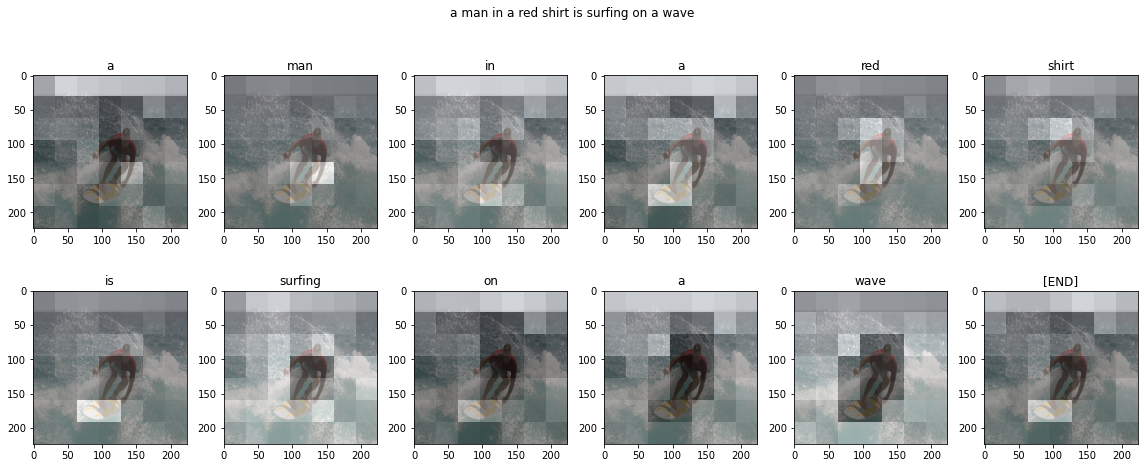

In [140]:
run_and_show_attention(model, image)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


67460/67460 [==============================] - 0s 1us/step


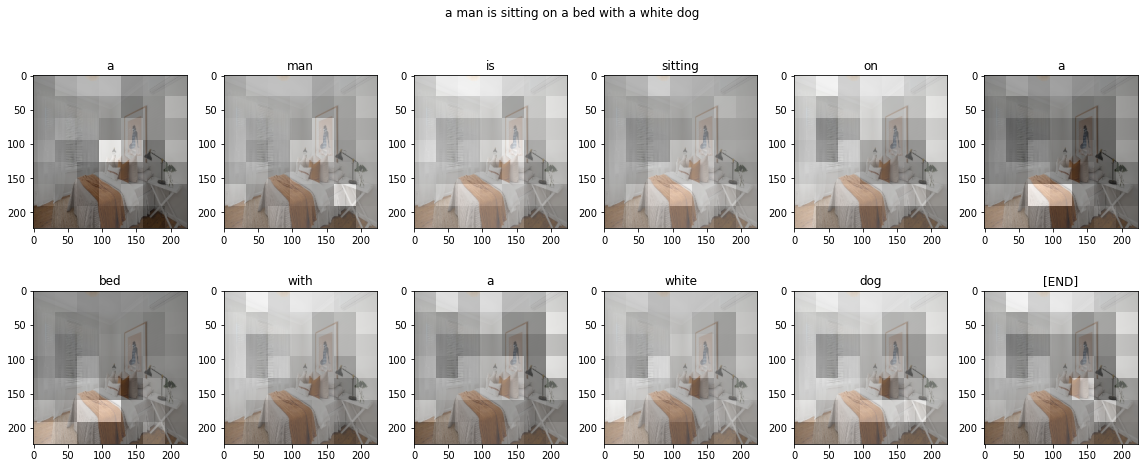

In [141]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)